<a href="https://colab.research.google.com/github/Glutamato/BasesSIR/blob/master/Copia_de_%5BPF_Bonus%5DCovid19_RealData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Funciones y dependencias necesarias

In [ ]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np 

## Importamos data de propagación del Covid-19
* repositorio: https://github.com/CSSEGISandData/COVID-19

In [ ]:
!git clone https://github.com/CSSEGISandData/COVID-19.git
confirmed = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
time = confirmed.columns[4:]
print(confirmed.columns[4:])

Cloning into 'COVID-19'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 36470 (delta 10), reused 16 (delta 9), pack-reused 36449
Receiving objects: 100% (36470/36470), 187.14 MiB | 30.38 MiB/s, done.
Resolving deltas: 100% (22018/22018), done.
Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '6/20/20', '6/21/20', '6/22/20', '6/23/20', '6/24/20', '6/25/20',
       '6/26/20', '6/27/20', '6/28/20', '6/29/20'],
      dtype='object', length=160)


## Pre-procesamiento
Un poco de transformaciones y preparacion de los datos, en este dataset, pueden haber varias filas para un mismo pais, porque cada fila contiene datos de cada provincia o region.

In [ ]:
# ejemplo de estructura de datos
confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481,29640,30175,30451,30616,30967,31238
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,969,981,989,998,1004,1029,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464,1521,1590,1672,1722,1788,1838,1891,1962,1995,2047,2114,2192,2269,2330,2402,2466
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810,10919,11031,11147,11268,11385,11504,11631,11771,11920,12076,12248,12445,12685,12968,13273,13571
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,762,762,762,762,763,763,763,763,764,764,764,765,844,851,852,852,852,852,852,852,852,852,853,853,853,853,854,854,855,855,855,855,855,855,855,855,855,855,855,855
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,58,60,61,69,70,70,71,74,81,84,86,86,86,86,86,86,88,91,92,96,113,118,130,138,140,142,148,155,166,172,176,183,186,189,197,212,212,259,267,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,251,251,251,251,299,441,443,458,463,479,483,484,484,484,485,499,499,513,513,514,611,632,639,659,661,662,671,683,688,693,698,698,702,707,710,711,712,713,713,713
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,197,209,212,222,233,249,256,278,283,310,323,354,399,419,453,469,482,484,496,524,560,591,632,705,728,844,885,902,909,919,922,941,967,992,1015,1076,1089,1103,1118,1128
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,34,78,78,87,87,87,87,87,87,106,106,106,132,132,132,132,141,141,141,141,162,162,163,176,176,176,197,197,210,210,247,247,247,265,265,272,272,272,272,272
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2350,2551,2738,2929,3100,3266,3424,3563,3686,3807,3930,4013,4100,4191,4289,4370,4453,4529,4609,4690,4763,4834,4902,4971,5035,5097,5160,5221,5279,5338,5399,5457,5513,5567,5630,5691,5747,5799,5849,5900


In [ ]:
# info para un solo país
confirmed[confirmed['Country/Region']=='China']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20
49,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,...,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991
50,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,...,593,593,593,593,593,593,593,593,593,593,593,593,593,594,594,594,594,594,594,594,594,595,601,637,673,700,731,752,777,777,821,830,843,850,863,874,891,905,912,919
51,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,...,579,579,579,579,579,579,579,579,579,579,579,579,579,579,579,579,579,579,579,579,579,579,579,580,582,582,582,582,582,582,582,582,582,582,582,582,582,582,582,582
52,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,...,356,356,356,356,357,357,358,358,358,358,358,358,358,358,358,358,359,359,359,359,360,361,361,361,362,362,362,362,362,362,363,363,363,363,363,363,363,363,363,363
53,Gansu,China,37.8099,101.0583,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,...,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,149,150,151,151,151,151,158,158,161,161,162,163,163,164
54,Guangdong,China,23.3417,113.4244,26,32,53,78,111,151,207,277,354,436,535,632,725,813,895,970,1034,1095,1131,1159,1177,1219,1241,1261,1294,1316,1322,1328,1331,1332,1333,1339,1342,1345,1347,1347,...,1590,1591,1592,1592,1592,1592,1592,1592,1593,1593,1595,1596,1597,1598,1598,1601,1602,1602,1604,1604,1607,1607,1608,1625,1625,1628,1628,1628,1631,1631,1634,1634,1634,1634,1635,1635,1637,1637,1637,1641
55,Guangxi,China,23.8298,108.7881,2,5,23,23,36,46,51,58,78,87,100,111,127,139,150,168,172,183,195,210,215,222,222,226,235,237,238,242,244,245,246,249,249,251,252,252,...,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254
56,Guizhou,China,26.8154,106.8748,1,3,3,4,5,7,9,9,12,29,29,38,46,58,64,71,81,89,99,109,127,133,135,140,143,144,146,146,146,146,146,146,146,146,146,146,...,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147
57,Hainan,China,19.1959,109.7453,4,5,8,19,22,33,40,43,46,52,62,64,72,80,99,106,117,124,131,138,144,157,157,159,162,162,163,163,168,168,168,168,168,168,168,168,...,169,169,169,169,169,169,169,169,169,169,169,169,169,169,169,169,170,170,170,170,170,170,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171
58,Hebei,China,39.5490,116.1306,1,1,2,8,13,18,33,48,65,82,96,104,113,126,135,157,172,195,206,218,239,251,265,283,291,300,301,306,306,307,308,309,311,311,311,312,...,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,331,335,336,338,340,340,344,346,346,348,349,349,349,349,349,349


In [ ]:
# colapsamos a totales del pais día día
confirmed[confirmed['Country/Region']=='China'].groupby('Country/Region').sum().iloc[:,2:]

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
China,548,643,920,1406,2075,2877,5509,6087,8141,9802,11891,16630,19716,23707,27440,30587,34110,36814,39829,42354,44386,44759,59895,66358,68413,70513,72434,74211,74619,75077,75550,77001,77022,77241,77754,78166,78600,78928,79356,79932,...,84063,84081,84084,84095,84102,84103,84106,84106,84123,84128,84146,84154,84161,84160,84171,84177,84186,84191,84195,84198,84209,84216,84228,84286,84335,84378,84422,84458,84494,84494,84553,84572,84624,84653,84673,84701,84725,84743,84757,84780


## Función que extrae datos por país

In [ ]:
# funcion que extrae los datos para un solo pais
# y los organiza por compartimiento poblacional 
# (en este caso "active" son los "infectados")
def get_timeseries(country):
  dic = {}
  dic['confirmed'] = confirmed[confirmed['Country/Region']==country].groupby('Country/Region').sum().iloc[:,2:].values
  dic['deaths'] = deaths[deaths['Country/Region']==country].groupby('Country/Region').sum().iloc[:,2:].values
  dic['recovered'] = recovered[recovered['Country/Region']==country].groupby('Country/Region').sum().iloc[:,2:].values
  dic['active'] = dic['confirmed']-dic['recovered']-dic['deaths']
  return dic

get_timeseries('China')

{'active': array([[  503,   595,   858,  1325,  1970,  2737,  5277,  5834,  7835,
          9375, 11357, 15806, 18677, 22373, 25762, 28477, 31393, 33413,
         35705, 37424, 38638, 38560, 52309, 56860, 57452, 57992, 58108,
         58002, 56541, 54825, 54608, 51859, 51390, 49631, 47413, 45365,
         42924, 39809, 37199, 34898, 32368, 29864, 27402, 25230, 23702,
         22159, 20335, 18933, 17567, 16116, 14859, 13569, 12124, 10783,
          9906,  9030,  8106,  7372,  6731,  6189,  5799,  5410,  5030,
          4603,  4310,  3881,  3600,  3236,  2967,  2764,  2640,  2545,
          2425,  2267,  2062,  2020,  1973,  1905,  1865,  1810,  1794,
          1835,  1829,  1761,  1699,  1656,  1572,  1537,  1479,  1436,
          1418,  1371,  1265,  1154,  1098,   998,   907,   881,   833,
           796,   749,   736,   643,   537,   461,   404,   361,   346,
           226,   206,   176,   159,   141,   131,   120,   113,   110,
           115,   115,   115,   115,   111,   111,   1

In [ ]:
# convertimos las fechas en string a formato datetime
from datetime import datetime
@np.vectorize
def convert_to_datetime(tt): return datetime.strptime(tt, '%m/%d/%y')
time_dt = convert_to_datetime(time)

## Visualización de propagación del virus por país

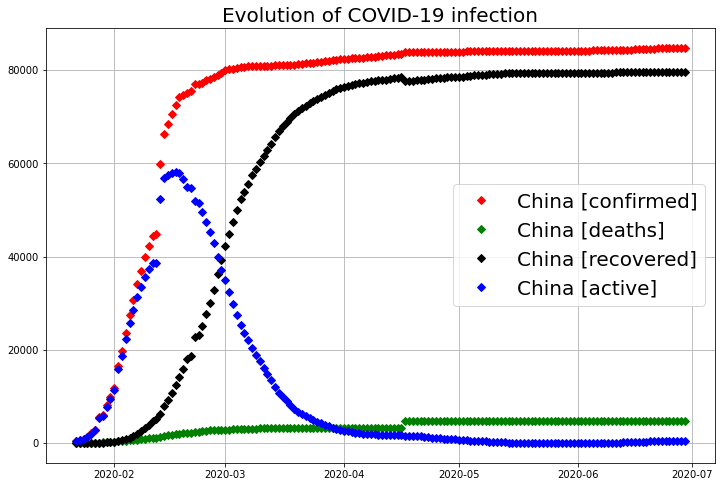

In [ ]:
def plot_country(country, lstyle = '-', marker = '*', ):
  dic = get_timeseries(country)
  fig = plt.figure(figsize = (12,8))
  plt.title('Evolution of COVID-19 infection', fontsize=20, loc='center')
  plt.plot_date(time_dt, dic['confirmed'][0], c = 'r', label = country+' [confirmed]', linestyle = lstyle, marker = marker)
  plt.plot_date(time_dt, dic['deaths'][0], c = 'g', label = country+' [deaths]', linestyle = lstyle, marker = marker)
  plt.plot_date(time_dt, dic['recovered'][0], c = 'k', label = country+' [recovered]', linestyle = lstyle, marker = marker)
  plt.plot_date(time_dt, dic['active'][0], c = 'b', label = country+' [active]', linestyle = lstyle, marker = marker)
  plt.legend(fontsize = 20)
  plt.grid(True)
  plt.show(fig)

plot_country('China', 'None', 'D')

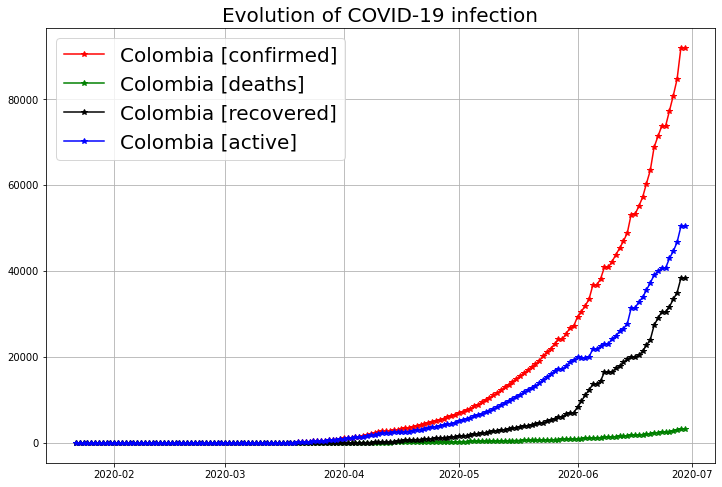

In [ ]:
plot_country('Colombia')